# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях».\
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.\
Чтобы решить эту проблему, нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.\
\
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

В таблицах hotel_train и hotel_test содержатся одинаковые столбцы:

- id— номер записи;
- adults— количество взрослых постояльцев;
- arrival_date_year— год заезда;
- arrival_date_month— месяц заезда;
- arrival_date_week_number— неделя заезда;
- arrival_date_day_of_month— день заезда;
- babies— количество младенцев;
- booking_changes— количество изменений параметров заказа;
- children— количество детей от 3 до 14 лет;
- country— гражданство постояльца;
- customer_type— тип заказчика:
	- Contract— договор с юридическим лицом;
	- Group— групповой заезд;
	- Transient— не связано с договором или групповым заездом;
	- Transient-party— не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- days_in_waiting_list— сколько дней заказ ожидал подтверждения;
- distribution_channel— канал дистрибуции заказа;
- is_canceled— отмена заказа;
- is_repeated_guest— признак того, что гость бронирует номер второй раз;
- lead_time— количество дней между датой бронирования и датой прибытия;
- meal— опции заказа:
	- SC— нет дополнительных опций;
	- BB— включён завтрак;
	- HB— включён завтрак и обед;
	- FB— включён завтрак, обед и ужин.
- previous_bookings_not_canceled— количество подтверждённых заказов у клиента;
- previous_cancellations— количество отменённых заказов у клиента;
- required_car_parking_spaces— необходимость места для автомобиля;
- reserved_room_type— тип забронированной комнаты;
- stays_in_weekend_nights— количество ночей в выходные дни;
- stays_in_week_nights— количество ночей в будние дни;
- total_nights— общее количество ночей;
- total_of_special_requests— количество специальных отметок.

### Шаг 1. Откройте файлы с данными

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df_train = pd.read_csv('/datasets/hotel_train.csv')
df_test = pd.read_csv('/datasets/hotel_test.csv')

In [5]:
display (df_train.head(5))
df_train.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

In [6]:
display (df_test.head(5))
df_test.info()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,0.0,0.0,BB,AUT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,0.0,0.0,BB,BEL,TA/TO,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

#### Поиск пропусков в данных

In [7]:
print (df_train.isna().sum())

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


In [8]:
print (df_test.isna().sum())

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64


#### Поиск явных дубликатов в данных

In [9]:
print (df_train.duplicated().sum())

0


In [10]:
print (df_test.duplicated().sum())

0


#### Поиск неявных дубликатов в данных

**Удаляю лишние пробелы в столбце 'reserved_room_type'**

In [11]:
#print (df_train['reserved_room_type'].unique())
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
print (df_train['reserved_room_type'].unique())

['A' 'C' 'D' 'E' 'G' 'F' 'B']


In [12]:
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
print (df_test['reserved_room_type'].unique())

['A' 'E' 'G' 'D' 'F' 'C' 'B']


**Ищу неявные дубликаты в столбце 'customer_type'**

In [13]:
print (df_train['customer_type'].unique())

['Transient' 'Contract' 'Transient-Party' 'Group']


**Удаляю лишние пробелы в столбце 'meal'**

In [14]:
#print (df_train['meal'].unique())
df_train['meal'] = df_train['meal'].str.strip()
print (df_train['meal'].unique())

['BB' 'FB' 'HB' 'SC']


In [15]:
df_test['meal'] = df_test['meal'].str.strip()
print (df_test['meal'].unique())

['BB' 'HB' 'SC' 'FB']


### Шаг 2. Предобработка и исследовательский анализ данных

#### Гистограммы столбцов

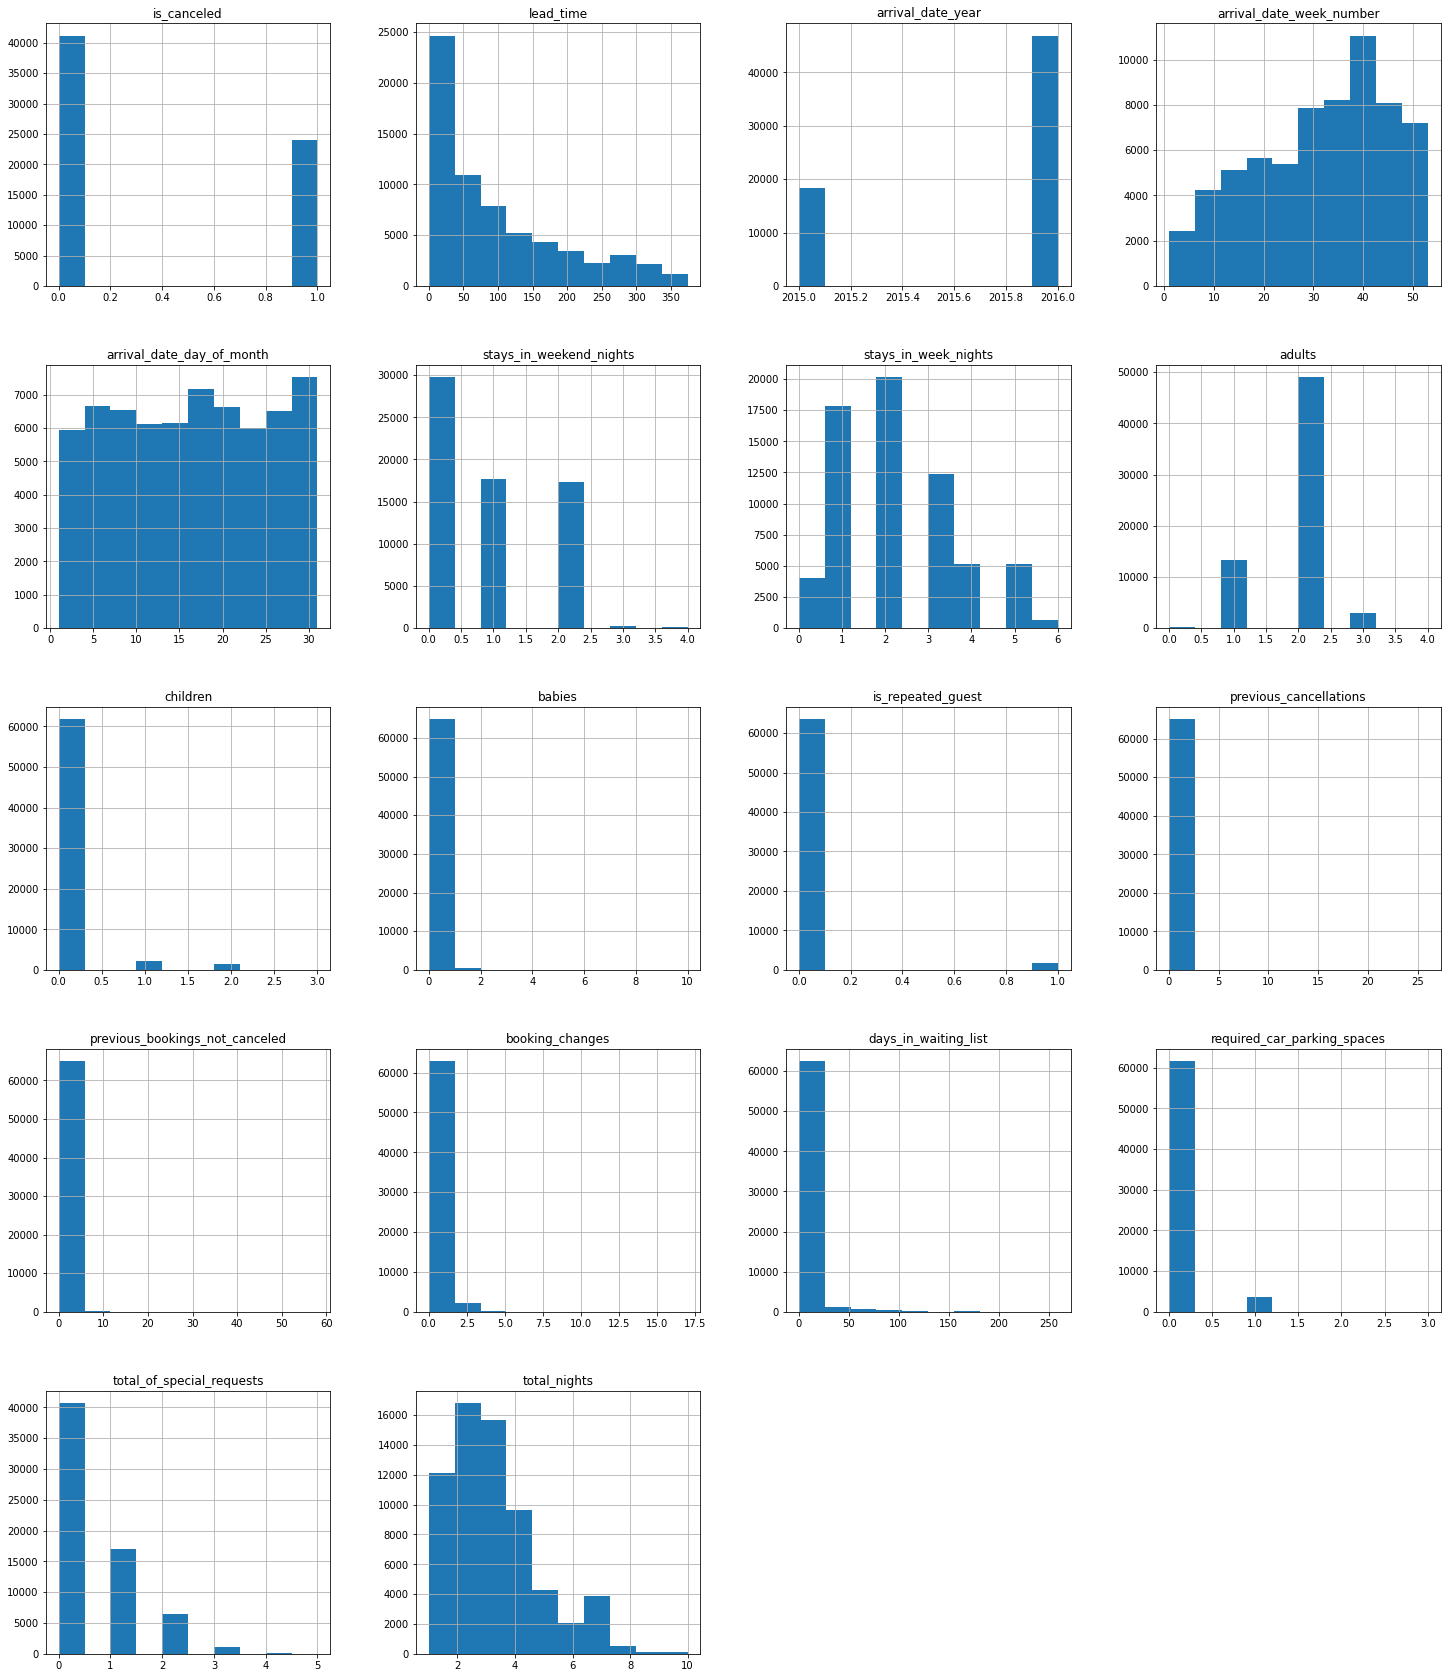

In [16]:
df_train.drop(['id'], axis=1).hist(figsize=(25,30))
None

####  Столбец 'lead_time' - количество дней между датой бронирования и датой прибытия

Изучаю подробнее график столбца lead_time, меня заинтересовал выброс около нуля.

<AxesSubplot:>

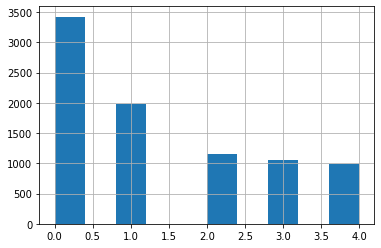

In [17]:
df_train.query('lead_time < 5')['lead_time'].hist()

Судя по графику, около 3500 постояльцев не бронировали номер заранее, а заказывали его прям в день заезда.

#### Графики столбцов 'customer_type', 'meal', 'reserved_room_type', 'arrival_date_month'

<AxesSubplot:>

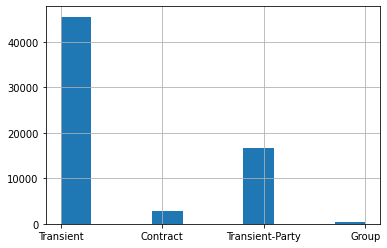

In [18]:
df_train['customer_type'].hist()

<AxesSubplot:>

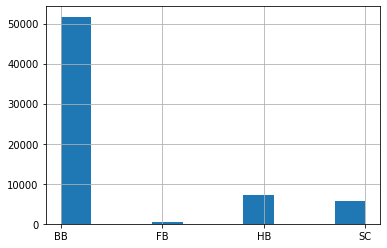

In [19]:
df_train['meal'].hist()

['A' 'C' 'D' 'E' 'G' 'F' 'B']


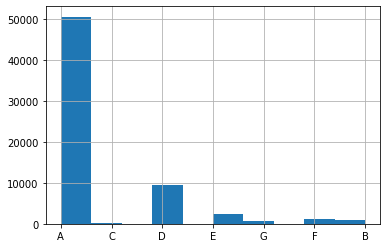

In [20]:
df_train['reserved_room_type'].hist()
print (df_train['reserved_room_type'].unique())

['July' 'August' 'September' 'October' 'November' 'December']


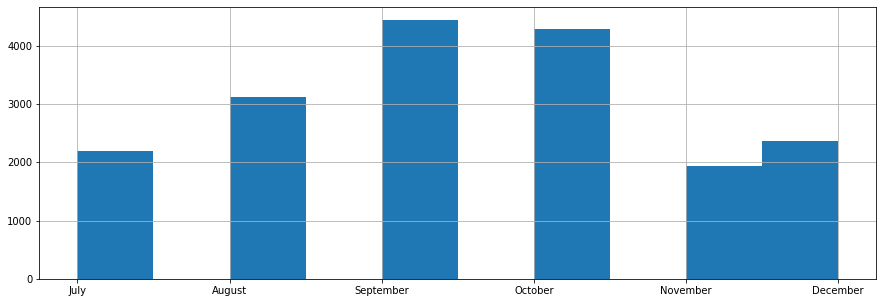

In [21]:
df_train.query('arrival_date_year==2015')['arrival_date_month'].hist(figsize=(15,5))
print (df_train.query('arrival_date_year==2015')['arrival_date_month'].unique())

['January' 'February' 'March' 'April' 'May' 'June' 'July' 'August'
 'September' 'October' 'November' 'December']


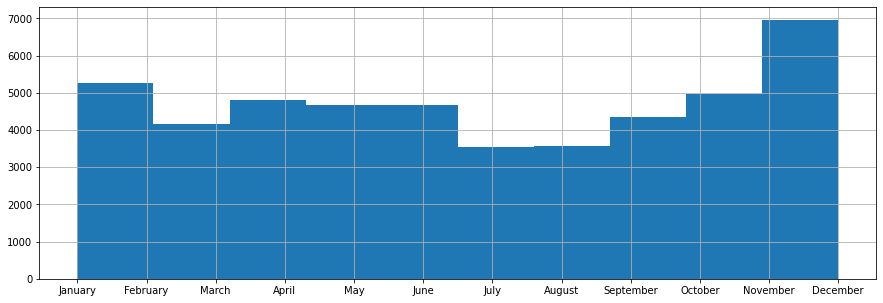

In [22]:
df_train.query('arrival_date_year==2016')['arrival_date_month'].hist(figsize=(15,5))
print (df_train.query('arrival_date_year==2016')['arrival_date_month'].unique())

У нас есть данные начиная с июля 2015 года и за весь 2016 год.

#### Столбец 'adults' - количество взрослых

In [23]:
df_train.query('adults == 0')['adults'].count()

166

In [24]:
display (df_train.query('adults == 0')['children'])
df_train.query('adults == 0 & children == 0')['adults'].count()

17540    3.0
17598    2.0
17982    2.0
21556    2.0
22516    3.0
        ... 
64751    3.0
64882    2.0
64892    2.0
64903    2.0
64980    0.0
Name: children, Length: 166, dtype: float64

15

Меня смутило, что в части номеров проживало 0 взрослых. Я предположила, что эти номера родители снимали отдельно для своих детей. Эта версия подтвердилась. В большинстве случаев, в номерах, в которых было 0 взрослых, проживали дети.\
\
Все равно остались бронирования, в которых было 0 взрослых и 0 детей. Видимо, это ошибка. Поскольку, таких бронирований всего 15, то я их оставляю без изменения, т.к. в других столбцах может содержаться важная информация.

#### Предварительный вывод по данным

is_canceled— отмена заказа - происходит больше, чем в половине случаев;\
lead_time— количество дней между датой бронирования и датой прибытия - большая часть бронирований происходит в промежутке от 0 до 30 дней до даты заезда;\
arrival_date_year— год заезда - информация в данных есть за 2015 и 2016 года;\
arrival_date_week_number— неделя заезда - наиболее популяной неделей для заезда являеся 40 неделя. Это, ориентировочно, начало октября;\
arrival_date_day_of_month— день заезда - дни заезда распределены достаточно равномерно. Но наиболее популярным для заезда являются 15-20 и 30 дни месяца;\
stays_in_weekend_nights— количество ночей в выходные дни - большинство гостей не остаются на выходные;\
stays_in_week_nights— количество ночей в будние дни - наибольшее количество бронирований приходится на 2й день недели. Вероятно, это вторник;\
\
adults — количество взрослых постояльцев - в основном бронируют двое постояльцев. Данный столбец я изучала подробнее выше. Меня смутило, что в части номеров проживало 0 взрослых. Я предположила, что эти номера родители снимали отдельно для своих детей. Эта версия подтвердилась. В большинстве случаев, в номерах, в которых было 0 взрослых, проживали дети.\
Все равно остались бронирования, в которых было 0 взрослых и 0 детей. Видимо, это ошибка. Поскольку, таких бронирований всего 15, то я их оставляю без изменения, т.к. в других столбцах может содержаться важная информация.\
\
total_nights— общее количество ночей - колеблется в промежутся от 1 до 10. Большинство постояльцев останавливаются на срок от двух до четрых ночей;\
meal— опции заказа - большинство заказов - это номера с завтраком;\
\
большинство значений остальных столбцов нулевые.

#### Создание столбца с номерами месяца заезда в номер

**Функция для создания столбца с номером месяца заезда в гостиничный номер**

In [25]:
def month_number (row):
    arrival_date_month = row ['arrival_date_month']
    if arrival_date_month == 'December':
        return 12
    elif arrival_date_month == 'January':
        return 1
    elif arrival_date_month == 'February':
        return 2
    elif arrival_date_month == 'March':
        return 3
    elif arrival_date_month == 'April':
        return 4
    elif arrival_date_month == 'May':
        return 5
    elif arrival_date_month == 'June':
        return 6
    elif arrival_date_month == 'July':
        return 7
    elif arrival_date_month == 'August':
        return 8
    elif arrival_date_month == 'September':
        return 9
    elif arrival_date_month == 'October':
        return 10
    elif arrival_date_month == 'November':
        return 11

df_train['arrival_date_month_number'] = df_train.apply(month_number, axis=1)
print (df_train[['arrival_date_month_number', 'arrival_date_month']])

df_test['arrival_date_month_number'] = df_test.apply(month_number, axis=1)
print (df_test[['arrival_date_month_number', 'arrival_date_month']])

       arrival_date_month_number arrival_date_month
0                              7               July
1                              7               July
2                              7               July
3                              7               July
4                              7               July
...                          ...                ...
65224                         12           December
65225                         12           December
65226                         12           December
65227                         12           December
65228                         12           December

[65229 rows x 2 columns]
       arrival_date_month_number arrival_date_month
0                              1            January
1                              1            January
2                              1            January
3                              1            January
4                              1            January
...                          ...      

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Рассчитываю прибыль отеля за 2016 год без внедрения депозитов

#### Создание столбца с рассчетом стоимости номера за сутки с учетом сезонного коэффициента

**Записываю стоимость номеров отеля**

In [26]:
A=1000
B=800
C=600
D=550
E=500
F=450
G=350

**Функция для рассчета стоимости номера за сутки с учетом сезонного коэффициента**

В столбец 'room_value_season' записываю стоимость номера за сутки с учетом сезонного коэффициента

In [27]:
def room_value (row):
    value_season = row ['arrival_date_month_number']
    type_room = row ['reserved_room_type']
    spring_autumn = [3, 4, 5, 9, 10, 11]
    summer = [6, 7, 8]
    winter = [12, 1, 2]
    if type_room == 'A':
        if value_season in spring_autumn:
            return (A+A/100*20)
        elif value_season in summer:
            return (A+A/100*40)
        elif value_season in winter:
            return A
    if type_room == 'B':
        if value_season in spring_autumn:
            return (B+B/100*20)
        elif value_season in summer:
            return (B+B/100*40)
        elif value_season in winter:
            return B
    if type_room == 'C':
        if value_season in spring_autumn:
            return (C+C/100*20)
        elif value_season in summer:
            return (C+C/100*40)
        elif value_season in winter:
            return C
    if type_room == 'D':
        if value_season in spring_autumn:
            return (D+D/100*20)
        elif value_season in summer:
            return (D+D/100*40)
        elif value_season in winter:
            return D
    if type_room == 'E':
        if value_season in spring_autumn:
            return (E+E/100*20)
        elif value_season in summer:
            return (E+E/100*40)
        elif value_season in winter:
            return E
    if type_room == 'F':
        if value_season in spring_autumn:
            return (F+F/100*20)
        elif value_season in summer:
            return (F+F/100*40)
        elif value_season in winter:
            return F
    if type_room == 'G':
        if value_season in spring_autumn:
            return (G+G/100*20)
        elif value_season in summer:
            return (G+G/100*40)
        elif value_season in winter:
            return G

df_train['room_value_season'] = df_train.apply(room_value, axis=1)
print (df_train[['room_value_season', 'reserved_room_type', 'arrival_date_month_number']])

df_test['room_value_season'] = df_test.apply(room_value, axis=1)
print (df_test[['room_value_season', 'reserved_room_type', 'arrival_date_month_number']])

       room_value_season reserved_room_type  arrival_date_month_number
0                 1400.0                  A                          7
1                 1400.0                  A                          7
2                  840.0                  C                          7
3                  840.0                  C                          7
4                 1400.0                  A                          7
...                  ...                ...                        ...
65224              550.0                  D                         12
65225              550.0                  D                         12
65226              550.0                  D                         12
65227             1000.0                  A                         12
65228             1000.0                  A                         12

[65229 rows x 3 columns]
       room_value_season reserved_room_type  arrival_date_month_number
0                 1000.0                  A        

#### Расчет прибыли отеля

##### Стоимость разового обслуживания номеров

In [28]:
SERVICE_A = 400
SERVICE_BC = 350
SERVICE_DEFG = 150

##### Функция для записи стоимости разового обслуживания номера в зависимости от его категории

In [29]:
def service_room_one_day (row):
    type_room = row ['reserved_room_type']
    if type_room == 'A':
        return SERVICE_A
    elif type_room == 'B':
        return SERVICE_BC
    elif type_room == 'C':
        return SERVICE_BC
    elif type_room == 'D':
        return SERVICE_DEFG
    elif type_room == 'E':
        return SERVICE_DEFG
    elif type_room == 'F':
        return SERVICE_DEFG
    elif type_room == 'G':
        return SERVICE_DEFG

df_train['service_room_one_day'] = df_train.apply(service_room_one_day, axis=1)
print (df_train[['service_room_one_day', 'reserved_room_type']])

df_test['service_room_one_day'] = df_test.apply(service_room_one_day, axis=1)
print (df_test[['service_room_one_day', 'reserved_room_type']])

       service_room_one_day reserved_room_type
0                       400                  A
1                       400                  A
2                       350                  C
3                       350                  C
4                       400                  A
...                     ...                ...
65224                   150                  D
65225                   150                  D
65226                   150                  D
65227                   400                  A
65228                   400                  A

[65229 rows x 2 columns]
       service_room_one_day reserved_room_type
0                       400                  A
1                       400                  A
2                       400                  A
3                       400                  A
4                       400                  A
...                     ...                ...
32407                   400                  A
32408                   400       

##### Функция для записи стоимости обслуживания номера при длительном проживании в номере

В условиях задачи указано, что при длительном проживании уборка проводится каждые 2 дня.\
Я предполагаю, что под длительным проживанием имеется ввиду проживание дольше 3х ночей.\
\
Не очень понимаю, что означает фраза, что "уборка проводится каждые 2 дня". Если это означает, что уборка производится через день, то количество проведенных в номере ночей необходимо просто делить на 2 и округлять.\
Если это означает, что уборка проводится через 2 дня на 3й день, то я делю количество ночей на 2, округляю и отнимаю 1 (я считаю таким способом).\
\
Не включаю в этот столбец стоимость первоначальной уборки номера при въезде.

In [30]:
def service_room_all_days (row):
    type_room = row ['reserved_room_type']
    total_nights = row ['total_nights']
    if type_room == 'A':
        if total_nights > 3:
            return (round(total_nights/2, 0) - 1)*SERVICE_A
        elif total_nights <= 3:
            return 0
    elif type_room == 'B':
        if total_nights > 3:
            return (round(total_nights/2, 0) - 1)*SERVICE_BC
        elif total_nights <= 3:
            return 0
    elif type_room == 'C':
        if total_nights > 3:
            return (round(total_nights/2, 0) - 1)*SERVICE_BC
        elif total_nights <= 3:
            return 0
    elif type_room == 'D':
        if total_nights > 3:
            return (round(total_nights/2, 0) - 1)*SERVICE_DEFG
        elif total_nights <= 3:
            return 0
    elif type_room == 'E':
        if total_nights > 3:
            return (round(total_nights/2, 0) - 1)*SERVICE_DEFG
        elif total_nights <= 3:
            return 0
    elif type_room == 'F':
        if total_nights > 3:
            return (round(total_nights/2, 0) - 1)*SERVICE_DEFG
        elif total_nights <= 3:
            return 0
    elif type_room == 'G':
        if total_nights > 3:
            return (round(total_nights/2, 0) - 1)*SERVICE_DEFG
        elif total_nights <= 3:
            return 0

df_train['service_room_all_days'] = df_train.apply(service_room_all_days, axis=1)
print (df_train[['service_room_all_days', 'reserved_room_type', 'total_nights']])

df_test['service_room_all_days'] = df_test.apply(service_room_all_days, axis=1)
print (df_test[['service_room_all_days', 'reserved_room_type', 'total_nights']])

       service_room_all_days reserved_room_type  total_nights
0                        0.0                  A             1
1                        0.0                  A             2
2                        0.0                  C             2
3                        0.0                  C             2
4                        0.0                  A             3
...                      ...                ...           ...
65224                  300.0                  D             6
65225                  150.0                  D             5
65226                  300.0                  D             6
65227                 1200.0                  A             7
65228                 1200.0                  A             7

[65229 rows x 3 columns]
       service_room_all_days reserved_room_type  total_nights
0                        0.0                  A             1
1                      400.0                  A             4
2                      400.0                

##### Прибыль от номеров, бронь на которые не была отменена

Считаю по такой формуле:\
Стоимость номера с учетом категории и коэффициента * количество дней - разовое обслуживание номера - уборка (раз в 2 дня)

In [31]:
df_train['room_value_total'] = df_train['room_value_season'] * df_train['total_nights']
print (df_train[['room_value_total', 'room_value_season', 'total_nights']])

df_test['room_value_total'] = df_test['room_value_season'] * df_test['total_nights']
print (df_test[['room_value_total', 'room_value_season', 'total_nights']])

       room_value_total  room_value_season  total_nights
0                1400.0             1400.0             1
1                2800.0             1400.0             2
2                1680.0              840.0             2
3                1680.0              840.0             2
4                4200.0             1400.0             3
...                 ...                ...           ...
65224            3300.0              550.0             6
65225            2750.0              550.0             5
65226            3300.0              550.0             6
65227            7000.0             1000.0             7
65228            7000.0             1000.0             7

[65229 rows x 3 columns]
       room_value_total  room_value_season  total_nights
0                1000.0             1000.0             1
1                4000.0             1000.0             4
2                4000.0             1000.0             4
3                4000.0             1000.0             4
4    

In [32]:
df_train['room_profit'] = df_train['room_value_total'] - df_train['service_room_one_day'] - df_train['service_room_all_days']
print (df_train[['room_profit', 'room_value_total', 'service_room_one_day', 'service_room_all_days']])
print ('Прибыль от номеров, бронь на которые не была отменена в 2015 году, составляет:', \
       df_train.query('is_canceled==0 & arrival_date_year == 2015')['room_profit'].sum(), 'рублей')
print ('Прибыль от номеров, бронь на которые не была отменена в 2016 году, составляет:', \
       df_train.query('is_canceled==0 & arrival_date_year == 2016')['room_profit'].sum(), 'рублей')

df_test['room_profit'] = df_test['room_value_total'] - df_test['service_room_one_day'] - df_test['service_room_all_days']

       room_profit  room_value_total  service_room_one_day  \
0           1000.0            1400.0                   400   
1           2400.0            2800.0                   400   
2           1330.0            1680.0                   350   
3           1330.0            1680.0                   350   
4           3800.0            4200.0                   400   
...            ...               ...                   ...   
65224       2850.0            3300.0                   150   
65225       2450.0            2750.0                   150   
65226       2850.0            3300.0                   150   
65227       5400.0            7000.0                   400   
65228       5400.0            7000.0                   400   

       service_room_all_days  
0                        0.0  
1                        0.0  
2                        0.0  
3                        0.0  
4                        0.0  
...                      ...  
65224                  300.0  
65225  

##### Убыток от номеров, бронь на которые была отменена

In [33]:
print ('Убыток от номеров, бронь на которые была отменена в 2015 году, составляет:', \
       df_train.query('is_canceled==1 & arrival_date_year == 2015')['service_room_one_day'].sum(), 'рублей')
print ('Убыток от номеров, бронь на которые была отменена в 2016 году, составляет:', \
       df_train.query('is_canceled==1 & arrival_date_year == 2016')['service_room_one_day'].sum(), 'рублей')

Убыток от номеров, бронь на которые была отменена в 2015 году, составляет: 2760750 рублей
Убыток от номеров, бронь на которые была отменена в 2016 году, составляет: 5837150 рублей


**Вывод:\
Прибыль от номеров, бронь на которые не была отменена в 2015 году, составила около 31,8 млн. рублей\
Прибыль от номеров, бронь на которые не была отменена в 2016 году, составила около 80,0 млн. рублей\
\
Убыток от номеров, бронь на которые была отменена в 2015 году, составил около 2,7 млн. рублей\
Убыток от номеров, бронь на которые была отменена в 2016 году, составил около 5,8 млн. рублей**

### Шаг 4. Разработка модели ML

#### Подготовка данных для исследования моделей

##### Исследование дисбаланса классов

0    0.631391
1    0.368609
Name: is_canceled, dtype: float64


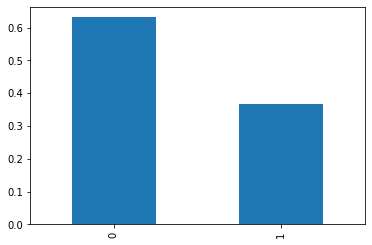

In [34]:
class_frequency = df_train['is_canceled'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
None

В целевом столбце выявлен дисбаланс классов. Нулей примерно вдвое больше, чем единиц.

##### Кодирую данные столбцов методом OHE

После кодировки данных я обнаружила, что у датафреймов тест и трейн разный размер. Ниже я ищу значения, которых нет в тесте.

In [35]:
df_train_unique = df_train['country'].unique() 
df_test_unique = df_test['country'].unique()
df_dif = []
for i in df_train_unique:
    if i not in df_test_unique:
        df_dif.append(i)
print (df_dif)

['BWA', 'SMR', 'CYM', 'GGY', 'ARM', 'OMN', 'BDI', 'PLW', 'MWI', 'KNA', 'HND', 'GEO', 'ZMB', 'KHM', 'NIC', 'VGB', 'MKD', 'TMP', 'GLP', 'MMR', 'BFA', 'MLI', 'NAM', 'BOL', 'BRB', 'DMA', 'PYF', 'UGA', 'GUY', 'LCA', 'RWA']


In [36]:
print (df_train['arrival_date_year'].unique())
print (df_test['arrival_date_year'].unique())

[2015 2016]
[2017]


In [37]:
df_test[['September', 'October', 'November', 'December']] = 0, 0, 0, 0
df_test[['BWA', 'SMR', 'CYM', 'GGY', 'ARM', 'OMN', 'BDI',\
          'PLW', 'MWI', 'KNA', 'HND', 'GEO', 'ZMB', 'KHM',\
          'NIC', 'VGB', 'MKD', 'TMP', 'GLP', 'MMR', 'BFA',\
          'MLI', 'NAM', 'BOL', 'BRB', 'DMA', 'PYF', 'UGA',\
          'GUY', 'LCA', 'RWA']] = 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0
df_test[['2015', '2016']] = 0, 0

In [38]:
df_train_ohe =  pd.get_dummies(df_train, \
                               columns=['arrival_date_year', 'arrival_date_month_number',\
                                       'arrival_date_week_number', 'arrival_date_day_of_month',\
                                        'reserved_room_type','total_of_special_requests',\
                                       'adults', 'children', 'babies', 'meal', 'country',\
                                       'distribution_channel', 'customer_type'], drop_first=True)
print (df_train_ohe.head(5))
df_test_ohe =  pd.get_dummies(df_test, \
                               columns=['arrival_date_year', 'arrival_date_month_number',\
                                       'arrival_date_week_number', 'arrival_date_day_of_month',\
                                        'reserved_room_type','total_of_special_requests',\
                                       'adults', 'children', 'babies', 'meal', 'country',\
                                       'distribution_channel', 'customer_type'], drop_first=True)

   id  is_canceled  lead_time arrival_date_month  stays_in_weekend_nights  \
0   0            0        7.0               July                        0   
1   1            0       14.0               July                        0   
2   2            0        0.0               July                        0   
3   3            0        9.0               July                        0   
4   4            1       85.0               July                        0   

   stays_in_week_nights  is_repeated_guest  previous_cancellations  \
0                     1                  0                       0   
1                     2                  0                       0   
2                     2                  0                       0   
3                     2                  0                       0   
4                     3                  0                       0   

   previous_bookings_not_canceled  booking_changes  days_in_waiting_list  \
0                               0       

In [39]:
print (df_train_ohe.shape)
print (df_test_ohe.shape)

(65229, 297)
(32412, 297)


##### Разбиваю данные df_train на train и valid в соотношении 80-20%

In [40]:
df_train, df_valid = train_test_split(df_train_ohe, test_size=0.2, random_state=12345)

features_train = df_train.drop(['is_canceled', 'id', 'arrival_date_month'], axis=1)
target_train = df_train['is_canceled']

features_valid = df_valid.drop(['is_canceled', 'id', 'arrival_date_month'], axis=1)
target_valid = df_valid['is_canceled']

features_test = df_test_ohe.drop(['is_canceled', 'id', 'arrival_date_month'], axis=1)
target_test = df_test_ohe['is_canceled']

##### Масштабирование признаков столбцов

In [41]:
numeric = ['lead_time', 'room_value_season', 'service_room_one_day', 'service_room_all_days',\
           'room_profit', 'room_value_total', 'days_in_waiting_list', 'total_nights',\
          'stays_in_weekend_nights', 'stays_in_week_nights']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

print(features_train.shape)
display (features_train.head(5))
display (features_test.head(5))

(52183, 294)


,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_nights,room_value_season,service_room_one_day,service_room_all_days,room_value_total,room_profit,arrival_date_year_2016,arrival_date_month_number_2,arrival_date_month_number_3,arrival_date_month_number_4,arrival_date_month_number_5,arrival_date_month_number_6,arrival_date_month_number_7,arrival_date_month_number_8,arrival_date_month_number_9,arrival_date_month_number_10,arrival_date_month_number_11,arrival_date_month_number_12,arrival_date_week_number_2,arrival_date_week_number_3,arrival_date_week_number_4,arrival_date_week_number_5,arrival_date_week_number_6,arrival_date_week_number_7,arrival_date_week_number_8,arrival_date_week_number_9,arrival_date_week_number_10,arrival_date_week_number_11,arrival_date_week_number_12,arrival_date_week_number_13,arrival_date_week_number_14,arrival_date_week_number_15,arrival_date_week_number_16,arrival_date_week_number_17,arrival_date_week_number_18,arrival_date_week_number_19,arrival_date_week_number_20,arrival_date_week_number_21,arrival_date_week_number_22,arrival_date_week_number_23,arrival_date_week_number_24,arrival_date_week_number_25,arrival_date_week_number_26,arrival_date_week_number_27,arrival_date_week_number_28,arrival_date_week_number_29,arrival_date_week_number_30,arrival_date_week_number_31,arrival_date_week_number_32,arrival_date_week_number_33,arrival_date_week_number_34,arrival_date_week_number_35,arrival_date_week_number_36,arrival_date_week_number_37,arrival_date_week_number_38,arrival_date_week_number_39,arrival_date_week_number_40,arrival_date_week_number_41,arrival_date_week_number_42,arrival_date_week_number_43,arrival_date_week_number_44,arrival_date_week_number_45,arrival_date_week_number_46,arrival_date_week_number_47,arrival_date_week_number_48,arrival_date_week_number_49,arrival_date_week_number_50,arrival_date_week_number_51,arrival_date_week_number_52,arrival_date_week_number_53,arrival_date_day_of_month_2,arrival_date_day_of_month_3,arrival_date_day_of_month_4,arrival_date_day_of_month_5,arrival_date_day_of_month_6,arrival_date_day_of_month_7,arrival_date_day_of_month_8,arrival_date_day_of_month_9,arrival_date_day_of_month_10,arrival_date_day_of_month_11,arrival_date_day_of_month_12,arrival_date_day_of_month_13,arrival_date_day_of_month_14,arrival_date_day_of_month_15,arrival_date_day_of_month_16,arrival_date_day_of_month_17,arrival_date_day_of_month_18,arrival_date_day_of_month_19,arrival_date_day_of_month_20,arrival_date_day_of_month_21,arrival_date_day_of_month_22,arrival_date_day_of_month_23,arrival_date_day_of_month_24,arrival_date_day_of_month_25,arrival_date_day_of_month_26,arrival_date_day_of_month_27,arrival_date_day_of_month_28,arrival_date_day_of_month_29,arrival_date_day_of_month_30,arrival_date_day_of_month_31,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,total_of_special_requests_1,total_of_special_requests_2,total_of_special_requests_3,total_of_special_requests_4,total_of_special_requests_5,adults_1.0,adults_2.0,adults_3.0,adults_4.0,children_1.0,children_2.0,children_3.0,babies_1.0,babies_2.0,babies_9.0,babies_10.0,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ATA,country_AUS,country_AUT,country_AZE,country_BDI,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_BWA,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,country_DEU,country_DMA,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FRA,country_GAB,country_GBR,country_GEO,country_GGY,country_GIB,country

,lead_time,stays_in_weekend_nights,stays_in_week_nights,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_nights,room_value_season,service_room_one_day,service_room_all_days,room_value_total,room_profit,September,October,November,December,BWA,SMR,CYM,GGY,ARM,OMN,BDI,PLW,MWI,KNA,HND,GEO,ZMB,KHM,NIC,VGB,MKD,TMP,GLP,MMR,BFA,MLI,NAM,BOL,BRB,DMA,PYF,UGA,GUY,LCA,RWA,2015,2016,arrival_date_month_number_2,arrival_date_month_number_3,arrival_date_month_number_4,arrival_date_month_number_5,arrival_date_month_number_6,arrival_date_month_number_7,arrival_date_month_number_8,arrival_date_week_number_2,arrival_date_week_number_3,arrival_date_week_number_4,arrival_date_week_number_5,arrival_date_week_number_6,arrival_date_week_number_7,arrival_date_week_number_8,arrival_date_week_number_9,arrival_date_week_number_10,arrival_date_week_number_11,arrival_date_week_number_12,arrival_date_week_number_13,arrival_date_week_number_14,arrival_date_week_number_15,arrival_date_week_number_16,arrival_date_week_number_17,arrival_date_week_number_18,arrival_date_week_number_19,arrival_date_week_number_20,arrival_date_week_number_21,arrival_date_week_number_22,arrival_date_week_number_23,arrival_date_week_number_24,arrival_date_week_number_25,arrival_date_week_number_26,arrival_date_week_number_27,arrival_date_week_number_28,arrival_date_week_number_29,arrival_date_week_number_30,arrival_date_week_number_31,arrival_date_week_number_32,arrival_date_week_number_33,arrival_date_week_number_34,arrival_date_week_number_35,arrival_date_day_of_month_2,arrival_date_day_of_month_3,arrival_date_day_of_month_4,arrival_date_day_of_month_5,arrival_date_day_of_month_6,arrival_date_day_of_month_7,arrival_date_day_of_month_8,arrival_date_day_of_month_9,arrival_date_day_of_month_10,arrival_date_day_of_month_11,arrival_date_day_of_month_12,arrival_date_day_of_month_13,arrival_date_day_of_month_14,arrival_date_day_of_month_15,arrival_date_day_of_month_16,arrival_date_day_of_month_17,arrival_date_day_of_month_18,arrival_date_day_of_month_19,arrival_date_day_of_month_20,arrival_date_day_of_month_21,arrival_date_day_of_month_22,arrival_date_day_of_month_23,arrival_date_day_of_month_24,arrival_date_day_of_month_25,arrival_date_day_of_month_26,arrival_date_day_of_month_27,arrival_date_day_of_month_28,arrival_date_day_of_month_29,arrival_date_day_of_month_30,arrival_date_day_of_month_31,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,total_of_special_requests_1,total_of_special_requests_2,total_of_special_requests_3,total_of_special_requests_4,total_of_special_requests_5,adults_1.0,adults_2.0,adults_3.0,adults_4.0,children_1.0,children_2.0,children_3.0,babies_1.0,babies_2.0,meal_FB,meal_HB,meal_SC,country_AGO,country_ALB,country_AND,country_ARE,country_ARG,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BEL,country_BEN,country_BGD,country_BGR,country_BHR,country_BHS,country_BIH,country_BLR,country_BRA,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_CPV,country_CRI,country_CUB,country_CYP,country_CZE,country_DEU,country_DNK,country_DOM,country_DZA,country_ECU,country_EGY,country_ESP,country_EST,country_ETH,country_FIN,country_FJI,country_FRA,country_FRO,country_GAB,country_GBR,country_GHA,country_GIB,country_GNB,country_GRC,country_GTM,country_HKG,country_HRV,country_HUN,country_IDN,country_IMN,country_IND,country_IRL,country_IRN,country_IRQ,country_ISL,country_ISR,country_ITA,country_JAM,country_JEY,country_JOR,country_JPN,country_KAZ,country_KEN,country_KIR,country_KOR,country_KWT,country_LAO,country_LBN,country_LBY,country_LIE,country_LKA,country_LTU,country_LUX,country_LVA,country_MAC,country_MAR,country_MCO,country_MDG,country_MDV,country_MEX,country_MLT,country_MNE,country_MOZ,country_MRT,country_MUS,country_MYS,country_MY

#### Исследую модель случайного леса

В нашем случае мы решаем задачу бинарной классификации. Выбираю для оценки моделей метрику F1 поскольку она является средним гармоническим точности и полноты.

In [42]:
%%time

best_model = None
best_result = 0
for est in range(1, 16):
    for depth in range(1, 16):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result

print("F1 наилучшей модели на валидационной выборке:", best_result)
print ("Какие гиперпараметры дали наилучший результат:", best_model)

F1 наилучшей модели на валидационной выборке: 0.7341118623232944
Какие гиперпараметры дали наилучший результат: RandomForestClassifier(max_depth=15, n_estimators=9, random_state=12345)
CPU times: user 1min 48s, sys: 12.2 s, total: 2min
Wall time: 2min 2s


**Строю ROC кривую для случайного леса и рассчитываю AUC-ROC (насколько сильно модель отличается от случайной)**

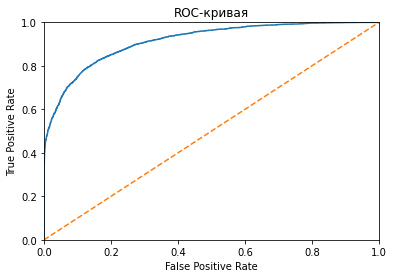

0.9146693504994177


In [43]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#рассчитываю AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid, multi_class='ovr')

print(auc_roc)

Из графика видно, что модель работает и отличается от случайной

#### Исследую модель логистической регрессии

In [44]:
%%time

best_model = None
best_result = 0
list_penalty = ['l1', 'l2']
list = [500, 600, 700]
for iter in list:
    for index in list_penalty:
        model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=iter, penalty=index)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result

print("F1 наилучшей модели на валидационной выборке:", best_result)
print ("Какие гиперпараметры дали наилучший результат:", best_model)

F1 наилучшей модели на валидационной выборке: 0.7295755362848014
Какие гиперпараметры дали наилучший результат: LogisticRegression(max_iter=500, penalty='l1', random_state=12345,
                   solver='liblinear')
CPU times: user 44.8 s, sys: 1.14 s, total: 46 s
Wall time: 46 s


**Строю ROC кривую для логистической регрессии и рассчитываю AUC-ROC (насколько сильно модель отличается от случайной)**

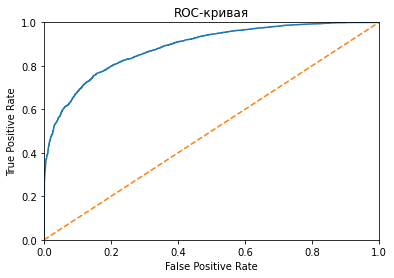

0.8858682957397368


In [45]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#рассчитываю AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid, multi_class='ovr')

print(auc_roc)

Из графика видно, что модель работает, а результат отличается от случайного

### Борьба с дисбалансом

#### Увеличиваю выборку для борьбы с дисбалансом

In [46]:
def upsample (features, target, repeat):
    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    repeat = 2
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled = shuffle (features_upsampled, random_state=12345)
    target_upsampled = shuffle (target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled
    
features_upsampled, target_upsampled = upsample(features_train, target_train, 2)

print(features_upsampled.shape)
print(target_upsampled.shape)

(71400, 294)
(71400,)


#### Модель случайного леса на увеличенной выборке

In [47]:
%%time

best_model = None
best_result = 0
for est in range(1, 15):
    for depth in range(1, 15):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result

print("F1 наилучшей модели на валидационной выборке:", best_result)
print ("Какие гиперпараметры дали наилучший результат:", best_model)

F1 наилучшей модели на валидационной выборке: 0.7859154929577465
Какие гиперпараметры дали наилучший результат: RandomForestClassifier(max_depth=13, n_estimators=14, random_state=12345)
CPU times: user 1min 54s, sys: 14.2 s, total: 2min 9s
Wall time: 2min 44s


#### ROC кривая для модели случайного леса на увеличенной выборке и рассчет AUC-ROC (насколько сильно модель отличается от случайной)

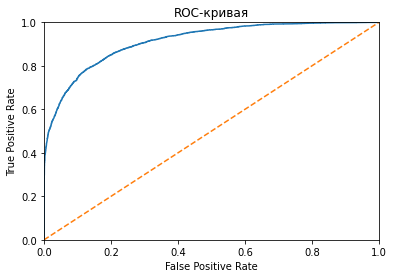

0.9135136685644003


In [48]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#рассчитываю AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid, multi_class='ovr')

print(auc_roc)

Из графика видно, что модель работает и отличается от случайной

#### Уменьшаю выборку для борьбы с дисбалансом

In [49]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.5)

print(features_downsampled.shape)
print(target_downsampled.shape)

(35700, 294)
(35700,)


#### Модель случайного леса на уменьшенной выборке

In [50]:
%%time

best_model = None
best_result = 0
for est in range(1, 15):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predictions_valid = model.predict(features_valid)
        result = f1_score(target_valid, predictions_valid)
        if result > best_result:
            best_model = model
            best_result = result

print("F1 наилучшей модели на валидационной выборке:", best_result)
print ("Какие гиперпараметры дали наилучший результат:", best_model)

F1 наилучшей модели на валидационной выборке: 0.7605958673714561
Какие гиперпараметры дали наилучший результат: RandomForestClassifier(max_depth=10, n_estimators=8, random_state=12345)
CPU times: user 33.3 s, sys: 3.47 s, total: 36.7 s
Wall time: 37.5 s


В результате уменьшения выборки F1 увеличилось по сравнению с выборкой до ее уменьшения, но метод увеличения выборки дал лучший результат.

#### ROC кривая для модели случайного леса на уменьшенной выборке и рассчет AUC-ROC (насколько сильно модель отличается от случайной)

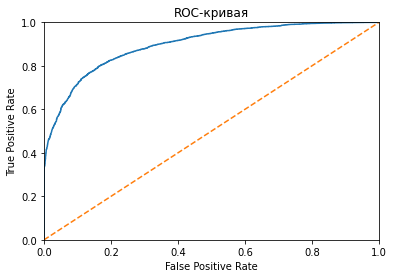

0.8976721211667962


In [51]:
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#рассчитываю AUC-ROC
auc_roc = roc_auc_score(target_valid, probabilities_one_valid, multi_class='ovr')

print(auc_roc)

Из графика видно, что модель работает и отличается от случайной

### Тестирование модели

#### Объединение тренировочных и валидационных данных

In [52]:
features_train_valid = pd.concat([features_upsampled, features_valid])
target_train_valid = pd.concat([target_upsampled, target_valid])
print (features_train_valid.shape)
print (target_train_valid.shape)

(84446, 294)
(84446,)


#### Делаю upsample для объединенной выборки

In [53]:
def upsample (features, target, repeat):
    features_zeros = features_train_valid[target_train_valid == 0]
    features_ones = features_train_valid[target_train_valid == 1]
    target_zeros = target_train_valid[target_train_valid == 0]
    target_ones = target_train_valid[target_train_valid == 1]
    repeat = 2
    features_upsampled_integrate = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled_integrate = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled_integrate = shuffle (features_upsampled, random_state=12345)
    target_upsampled_integrate = shuffle (target_upsampled, random_state=12345)
    return features_upsampled_integrate, target_upsampled_integrate
    
features_upsampled_integrate, target_upsampled_integrate = upsample(features_train_valid, target_train_valid, 2)

print(features_upsampled_integrate.shape)
print(target_upsampled_integrate.shape)

(71400, 294)
(71400,)


#### Проверка на тестовой выборке модели случайного леса

In [54]:
model = RandomForestClassifier(max_depth=13, n_estimators=14, random_state=12345)
model.fit(features_upsampled_integrate, target_upsampled_integrate)
predictions_test = model.predict(features_test)

f1 = f1_score(target_test, predictions_test)
print ('F1 тестовой выборки случайного леса', f1)

F1 тестовой выборки случайного леса 0.34825574473151566


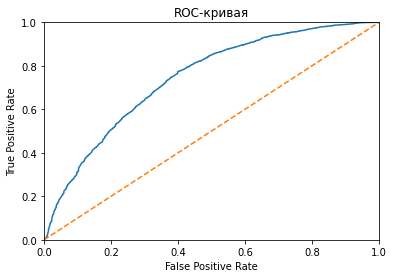

0.7427656382538099


In [55]:
probabilities_valid = model.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)

plt.figure()
plt.plot(fpr, tpr)

# ROC-кривая случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

#рассчитываю AUC-ROC
auc_roc = roc_auc_score(target_test, probabilities_one_valid, multi_class='ovr')

print(auc_roc)

Из графика видно, что модель работает и отличается от случайной

### Расчет предполагаемой прибыли от внедрения модели

#### Записываю predictions в отдельный столбец

In [56]:
df_test ['is_cancelled_predicted'] = pd.Series(predictions_test)
#print (df_test.head(5))

In [57]:
df_test['deposit'] = (df_test['room_value_season'] + df_test['service_room_one_day'])/100*80

#### Сравниваю рассчитанную моделью прибыль с фактической прибылью

In [58]:
print ('Фактическая прибыль от номеров, бронь на которые не была отменена в 2017 году, составляет:', \
       df_test.query('is_canceled==0 & arrival_date_year == 2017')['room_profit'].sum(), 'рублей')
print ('Фактический убыток от номеров, бронь на которые была отменена в 2017 году, составляет:', \
       df_test.query('is_canceled==1 & arrival_date_year == 2017')['service_room_one_day'].sum(), 'рублей')

Фактическая прибыль от номеров, бронь на которые не была отменена в 2017 году, составляет: 55307680.0 рублей
Фактический убыток от номеров, бронь на которые была отменена в 2017 году, составляет: 4286800 рублей


In [59]:
deposit_predicted =  df_test.query('is_cancelled_predicted==1 & arrival_date_year == 2017')['deposit'].sum()
service_room_predicted = df_test.query('is_cancelled_predicted==1 & arrival_date_year == 2017')['service_room_one_day'].sum()
room_value_season_predicted = df_test.query('is_cancelled_predicted==1 & arrival_date_year == 2017')['room_value_season'].sum()
profit_predicted = deposit_predicted - service_room_predicted - room_value_season_predicted

print ('При внедрении модели: на сколько увеличится прибыль отеля при внедрении депозитов:', \
       service_room_predicted, 'рублей')

При внедрении модели: на сколько увеличится прибыль отеля при внедрении депозитов: 1558300 рублей


**Вывод: если ввести депозиты для клиентов, которые (как предполагает модель) отменят бронь, то прибыль отеля за год на депозитах увеличится на 4,6 млн. руб.**

### Шаг 5. Опишите портрет «ненадёжного» клиента

<AxesSubplot:>

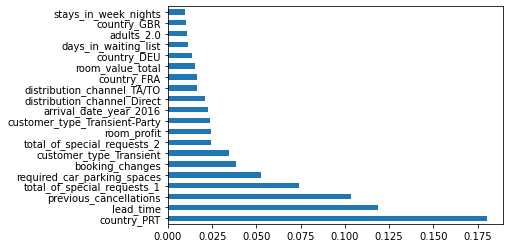

In [60]:
feat_importances = pd.Series(model.feature_importances_, index=features_train_valid.columns)
feat_importances.nlargest(20).plot(kind='barh')

Наиболее часто отменяют заказы клиенты со следующими характеристиками:\
Страна PRT (наверное, Португалия)\
Которые раньше отменяли заказы\
Которые бронируют заранее\
У которых есть один специальный запрос\
Которым требуется парковочное место.

### Шаг 6. Напишите общий вывод

Заказчик этого исследования — сеть отелей «Как в гостях».\
Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.\
Задачей исследования была разработка системы предсказания отказа от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.\
\
На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.\
\
**Предварительно я изучила данные**\
is_canceled— отмена заказа - происходит больше, чем в половине случаев;\
lead_time— количество дней между датой бронирования и датой прибытия - большая часть бронирований происходит в промежутке от 0 до 30 дней до даты заезда;\
arrival_date_year— год заезда - информация в данных есть за 2015 и 2016 года (в трейне) и за 2017 год в тесте;\
arrival_date_week_number— неделя заезда - наиболее популяной неделей для заезда являеся 40 неделя. Это, ориентировочно, начало октября;\
arrival_date_day_of_month— день заезда - дни заезда распределены достаточно равномерно. Но наиболее популярным для заезда являются 15-20 и 30 дни месяца;\
stays_in_weekend_nights— количество ночей в выходные дни - большинство гостей не остаются на выходные;\
stays_in_week_nights— количество ночей в будние дни - наибольшее количество бронирований приходится на 2й день недели. Вероятно, это вторник;\
\
adults — количество взрослых постояльцев - в основном бронируют двое постояльцев. Данный столбец я изучала подробнее выше. Меня смутило, что в части номеров проживало 0 взрослых. Я предположила, что эти номера родители снимали отдельно для своих детей. Эта версия подтвердилась. В большинстве случаев, в номерах, в которых было 0 взрослых, проживали дети.\
Все равно остались бронирования, в которых было 0 взрослых и 0 детей. Видимо, это ошибка. Поскольку, таких бронирований всего 15, то я их оставляю без изменения, т.к. в других столбцах может содержаться важная информация.\
\
total_nights— общее количество ночей - колеблется в промежутся от 1 до 10. Большинство постояльцев останавливаются на срок от двух до четрых ночей;\
meal— опции заказа - большинство заказов - это номера с завтраком.\
\
**Портрет ненадежного клиента**\
Наиболее часто отменяют заказы клиенты со следующими характеристиками:\
Страна PRT (наверное, Португалия)\
Которые раньше отменяли заказы\
Которые бронируют заранее\
У которых есть один специальный запрос\
Которым требуется парковочное место.\
\
**Исследование моделей**\
Я исследовала две модели. В результате исследования, я выяснила, что модель случайного леса показала результат, лучше случайного.\
При внедрении модели прибыль отеля увеличится на 4,6 млн. руб. в год. Предполагаемая прибыль за год выше стоимости внедрения модели (400 тыс. руб.), следовательно, можно рекомендовать ее внедрение.\